In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install pingouin

     |████████████████████████████████| 204kB 12.0MB/s 
  Created wheel for pingouin: filename=pingouin-0.3.11-cp37-none-any.whl size=203325 sha256=67392379862380e078254e28ae30385f0f351c86d8124a8e82a9146f1001e128
  Stored in directory: /root/.cache/pip/wheels/79/46/ef/e377eb45c86f278f660d31c4a30e3f733063d28c89462f1aea
  Created wheel for littleutils: filename=littleutils-0.2.2-cp37-none-any.whl size=7051 sha256=4f17a640acfc0098560aca7af96f6a29ad4d32789acd10f436c8b257bbdedfbb
  Stored in directory: /root/.cache/pip/wheels/53/16/9f/ac67d15c40243754fd73f620e1b9b6dedc20492ecc19a2bae1
Successfully built pingouin littleutils


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import *
import pingouin as pg
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import pandas as pd

In [ ]:
Tangent_Matrices = np.load("/content/gdrive/MyDrive/COL786/Project_Data/tangent_cc400_PIQ.npy")
Labels = np.load("/content/gdrive/MyDrive/COL786/Project_Data/labels_cc400_PIQ.npy")
ROI = pd.read_csv("/content/gdrive/MyDrive/COL786/Project_Data/CC400_ROI_labels.csv")

In [ ]:
p_thresh = 0.01
significant = []
for j in range(Tangent_Matrices.shape[1]):
  for k in range(j+1,Tangent_Matrices.shape[2]):
    wt = []
    iq = []
    for i in range(Tangent_Matrices.shape[0]):
      wt.append(Tangent_Matrices[i,j,k])
      iq.append(Labels[i])
    c = pg.corr(wt,iq,method='bicor')
    if c['p-val'].values[0] < p_thresh:
      significant.append((j,k))


In [ ]:
# X = []
# # Threshold = 0

# for k in range(Tangent_Matrices.shape[0]):
#   ls = []
#   for i in range(Tangent_Matrices.shape[1]):
#     for j in range(i+1,Tangent_Matrices.shape[2]):
#       val = Tangent_Matrices[k,i,j]
#       ls.append(val)
  
#   X.append(ls)

# X = np.array(X)


In [ ]:
X = []
# Threshold = 0
for k in range(Tangent_Matrices.shape[0]):
  ls = []
  for ids in significant:
    val = Tangent_Matrices[k,ids[0],ids[1]]
    ls.append(val)
  X.append(ls)

X = np.array(X)

In [ ]:
print(X.shape)

(751, 1104)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Labels, test_size=0.1, random_state=42)

In [ ]:
inputs = Input(shape=(X.shape[1],), name="input")
x = Dense(100, activation="relu", kernel_regularizer=l1_l2(l1=0, l2=5), name="dense_1")(inputs)
outputs = Dense(1, activation="relu", kernel_regularizer=l1_l2(l1=0, l2=5), name="dense_2")(x)
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss='mean_squared_error', optimizer="adam", metrics = tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1104)]            0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               110500    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 110,601
Trainable params: 110,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint_filepath = '/content/gdrive/MyDrive/COL786/Project_Data/tangent_cc400_PIQ.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_root_mean_squared_error',
    mode='min',
    save_best_only=True)

model.fit(x = X_train, y = y_train, batch_size=256, epochs = 1000, validation_data = (X_test, y_test), callbacks=[model_checkpoint_callback])

Epoch 1/1000
3/3 [==============================] - 1s 93ms/step - loss: 12665.7510 - root_mean_squared_error: 108.4428 - val_loss: 12327.0146 - val_root_mean_squared_error: 107.2901
Epoch 2/1000
3/3 [==============================] - 0s 24ms/step - loss: 12520.4919 - root_mean_squared_error: 108.2766 - val_loss: 12222.8750 - val_root_mean_squared_error: 107.2751
Epoch 3/1000
3/3 [==============================] - 0s 23ms/step - loss: 12427.4351 - root_mean_squared_error: 108.3045 - val_loss: 12127.7080 - val_root_mean_squared_error: 107.2563
Epoch 4/1000
3/3 [==============================] - 0s 25ms/step - loss: 12292.6187 - root_mean_squared_error: 108.0943 - val_loss: 12040.8252 - val_root_mean_squared_error: 107.2319
Epoch 5/1000
3/3 [==============================] - 0s 23ms/step - loss: 12296.6848 - root_mean_squared_error: 108.4818 - val_loss: 11962.0068 - val_root_mean_squared_error: 107.2035
Epoch 6/1000
3/3 [==============================] - 0s 23ms/step - loss: 12160.5542 -

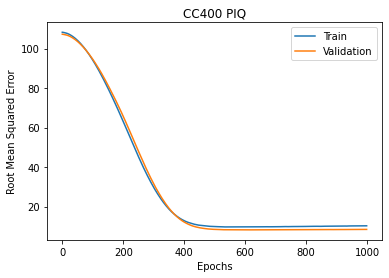

In [ ]:
plt.plot(model.history.history["root_mean_squared_error"], label = "Train") 
plt.plot(model.history.history["val_root_mean_squared_error"], label = "Validation")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")
plt.title("CC400 PIQ")
plt.show()

In [ ]:
model = load_model(checkpoint_filepath)

In [ ]:
y_pred = model.predict(X_test).flatten()
coefficient_of_dermination = r2_score(y_test, y_pred)
print(coefficient_of_dermination)

0.523268604200389


In [ ]:
np.sqrt(mean_squared_error(y_test, y_pred))

8.205383764834925

In [ ]:
watch_data = X_test[10,:]


watch_layer = model.get_layer("input")
watch_model = Model(model.inputs,watch_layer.output)

regression_input = Input(shape=watch_layer.output.shape[1:])
x = model.get_layer("dense_1")(regression_input)
regression_output = model.get_layer("dense_2")(x)

regression_model = Model(regression_input, regression_output)

with tf.GradientTape() as tape:
  output = watch_model(np.expand_dims(watch_data,axis=0))
  tape.watch(output)
  preds = regression_model(output)

grads = tape.gradient(preds, output).numpy()
output = output.numpy()

heat_map = np.multiply(grads,output)


In [ ]:
ids = np.argsort(heat_map)
sorted = np.sort(heat_map)

In [ ]:
Results_neg = []
for i in range(5):

  r1 = ROI._get_value(significant[ids[0,i]][0], 'AAL').split("\"")[1]
  r2 = ROI._get_value(significant[ids[0,i]][1], 'AAL').split("\"")[1]

  Results_neg.append([r1,r2,sorted[0,i]])

Results_pos = []

for i in range(5):

  r1 = ROI._get_value(significant[ids[0,-(i+1)]][0], 'AAL').split("\"")[1]
  r2 = ROI._get_value(significant[ids[0,-(i+1)]][1], 'AAL').split("\"")[1]

  Results_pos.append([r1,r2,sorted[0,-(i+1)]])

In [ ]:
print(Results_neg)

[['Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_L', -0.99133563], ['Frontal_Sup_Medial_R', 'Frontal_Sup_Medial_L', -0.89088416], ['Postcentral_R', 'Supp_Motor_Area_L', -0.3166156], ['Angular_R', 'Frontal_Sup_Medial_R', -0.29719543], ['Postcentral_R', 'SupraMarginal_R', -0.2754921]]


In [ ]:
print(Results_pos)

[['Occipital_Mid_R', 'Frontal_Med_Orb_R', 0.35438293], ['Frontal_Sup_R', 'Frontal_Sup_L', 0.3297888], ['Hippocampus_R', 'Cingulum_Mid_R', 0.3239986], ['Occipital_Sup_R', 'Parietal_Sup_R', 0.2423549], ['Parietal_Sup_L', 'Parietal_Inf_L', 0.23832896]]


In [ ]:
print(sorted[0,:5])
print(sorted[0,-5:])

[-0.99133563 -0.89088416 -0.3166156  -0.29719543 -0.2754921 ]
[0.23832896 0.2423549  0.3239986  0.3297888  0.35438293]


In [ ]:
for id in ids[0,:5]:
  print(significant[id])

(81, 383)
(138, 383)
(78, 287)
(7, 138)
(22, 111)


In [ ]:
for id in ids[0,-5:]:
  print(significant[id])

(177, 354)
(225, 369)
(204, 252)
(89, 245)
(131, 228)
